img.shape： (561, 728, 3)
561 728
torch.Size([1, 2042040, 4])


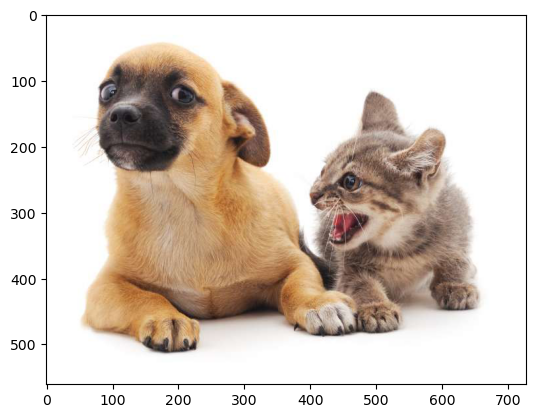

In [9]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt

def multibox_prior(data,sizes,ratios):
    """生成以每个像素为中心具有不同高宽度的锚框"""
    # data.shape的最后两个元素为宽和高，第一个元素为通道数
    in_height, in_width = data.shape[-2:]
    # 数据对应的设备、锚框占比个数、锚框高宽比个数
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 计算每个像素点对应的锚框数量
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    # 将锚框占比列表转为张量并将其移动到指定设备
    size_tensor = torch.tensor(sizes, device=device)
    # 将宽高比列表转为张量并将其移动到指定设备
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # 定义锚框中心偏移量
    offset_h, offset_w = 0.5, 0.5
    # 计算高度方向上的步长
    steps_h = 1.0 / in_height
    # 计算宽度方向上的步长
    steps_w = 1.0 / in_width
    
    # 生成归一化的高度和宽度方向上的像素点中心坐标
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # 生成坐标网格
    shift_y, shift_x = torch.meshgrid(center_h, center_w,indexing='ij')
    # 将坐标网格平铺为一维
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 计算每个锚框的宽度和高度
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                  sizes[0] * torch.sqrt(ratio_tensor[1:]))) \
                    * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                  sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 计算锚框的左上角和右下角坐标（相对于锚框中心的偏移量）
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    '''
    torch.stack:新增一个维度把输入的张量堆起来
    .repeat(num1,num2):第0维重复num1次，第1维重复num2次
    '''
    # 计算所有锚框的中心坐标，每个像素对应boxes_per_pixel个锚框
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    '''关于torch.stack的dim参数在md文件中写了一些自己的理解'''
    # 通过中心坐标和偏移量计算所有锚框的左上角和右下角坐标
    output = out_grid + anchor_manipulations
    
    # 增加一个维度并返回结果
    return output.unsqueeze(0)

img = plt.imread('img/catdog.jpg')
plt.imshow(img)

# plt.show()   #这一行执行时图片会立马渲染，否则图片会出现在所有print语句的输出之后

print("img.shape：",img.shape) # 高561，宽72，3通道
h, w = img.shape[:2]
print(h,w)

X = torch.rand(size=(1,3,h,w)) # 批量大小为1,3通道
Y = multibox_prior(X, sizes=[0.75,0.5,0.25], ratios=[1,2,0.5]) # 占图片sizes尺寸的大小、高宽比ratios尺寸大小的锚框
print(Y.shape) # 1 是批量大小，2042040是一张图片生成的锚框数量，4个元素时每个锚框对应的位置